## Notebook 03: Feature Engineering and Model Building

### Objective
In this notebook, we will prepare our cleaned dataset for machine learning model training. Our objectives include:

- **Data Splitting:** Dividing the dataset into training, validation, and test sets to ensure robust model evaluation.
- **Feature Engineering:** Creating new features from existing ones to enhance the predictive power of our models (e.g., time-based features, categorical encoding, interaction terms).
- **Model Selection and Building:** Exploring and implementing various machine learning models suitable for predicting food delivery times.
- **Model Training:** Training selected models using the prepared training data.

### Problem Context
Building upon the insights gained from `Notebook 02`'s Exploratory Data Analysis, this phase is critical for transforming raw data into a format that machine learning models can effectively learn from. By carefully engineering features and selecting appropriate models, we aim to develop a predictive solution that can accurately estimate food delivery times. The performance of these models, evaluated in subsequent stages, will directly impact the efficiency of delivery operations and customer satisfaction.

### Step 1: Import Libraries

We'll start by importing the necessary Python libraries for data manipulation and analysis.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',100)
print("Libraries loaded successfully!")

Libraries loaded successfully!


### Step 2: Load Dataset

Now, let's load the cleaned `Food_Delivery_Times.csv` dataset into a Pandas DataFrame.

In [7]:
df = pd.read_csv('../data/processed/clean_food_delivery_times.csv')
print("Dataset loaded successfully!")

Dataset loaded successfully!


### Step 3: Data Inspection and Preprocessing Overview

Before diving into feature engineering and splitting, let's get a quick overview of our dataset's structure and summary statistics.

In [8]:
print("DataFrame Info:")
df.info()

print("\nDataFrame Description:")
display(df.describe(include='number').T)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 1000 non-null   object 
 3   Traffic_Level           1000 non-null   object 
 4   Time_of_Day             1000 non-null   object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  1000 non-null   float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB

DataFrame Description:


,count,mean,std,min,25%,50%,75%,max
Order_ID,1000.0,500.500000,288.819436,1.00,250.750,500.500000,750.2500,1000.00
Distance_km,1000.0,10.059970,5.696656,0.59,5.105,10.190000,15.0175,19.99
Preparation_Time_min,1000.0,16.982000,7.204553,5.00,11.000,17.000000,23.0000,29.00
Courier_Experience_yrs,1000.0,4.579381,2.870301,0.00,2.000,4.579381,7.0000,9.00
Delivery_Time_min,1000.0,56.732000,22.070915,8.00,41.000,55.500000,71.0000,153.00


### Step 4: Data Splitting

We'll split the dataset into features (X) and the target variable (y), which is `Delivery_Time_min`. Then, we'll further divide the data into training, validation, and test sets to ensure robust model evaluation.

In [9]:
# Separate target variable (y) from features (X)
X = df.drop(['Delivery_Time_min', 'Order_ID'], axis=1)
y = df['Delivery_Time_min']

# Split data into training and the rest (validation + test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (700, 7)
y_train shape: (700,)
X_test shape: (300, 7)
y_test shape: (300,)


### Step 5: Feature Engineering

We will identify numerical and categorical features and apply appropriate preprocessing steps to them. For numerical features, we'll use `StandardScaler` for normalization. For categorical features, we'll use `OneHotEncoder` to convert them into a numerical format suitable for machine learning models. We will use `ColumnTransformer` to apply these transformations concurrently.

In [10]:
# Identify numerical and categorical columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

### Step 6: Model Evaluation

We will evaluate the performance of our trained Linear Regression model using common regression metrics such as Mean Squared Error (MSE) and R-squared ($R^2$). We will first evaluate on the validation set and then on the test set to ensure a robust assessment of the model's generalization capabilities.

In [11]:
linear_model.fit(X_train, y_train)
y_test_pred = linear_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"R-squared (R2): {r2_test:.2f}")

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='r2')
print("CV Mean R2:", cv_scores.mean())
print("CV Std:", cv_scores.std())


Test Set Evaluation:
Mean Absolute Error (MAE): 6.02
R-squared (R2): 0.83
CV Mean R2: 0.7383192469101084
CV Std: 0.057051349176697554


### Step 7: Residual Analysis

To further understand our model's performance and identify potential areas for improvement, we will analyze the residuals. Residuals are the differences between the actual and predicted values. By plotting them, we can check for patterns, heteroscedasticity, or non-linearity that the model might not be capturing.

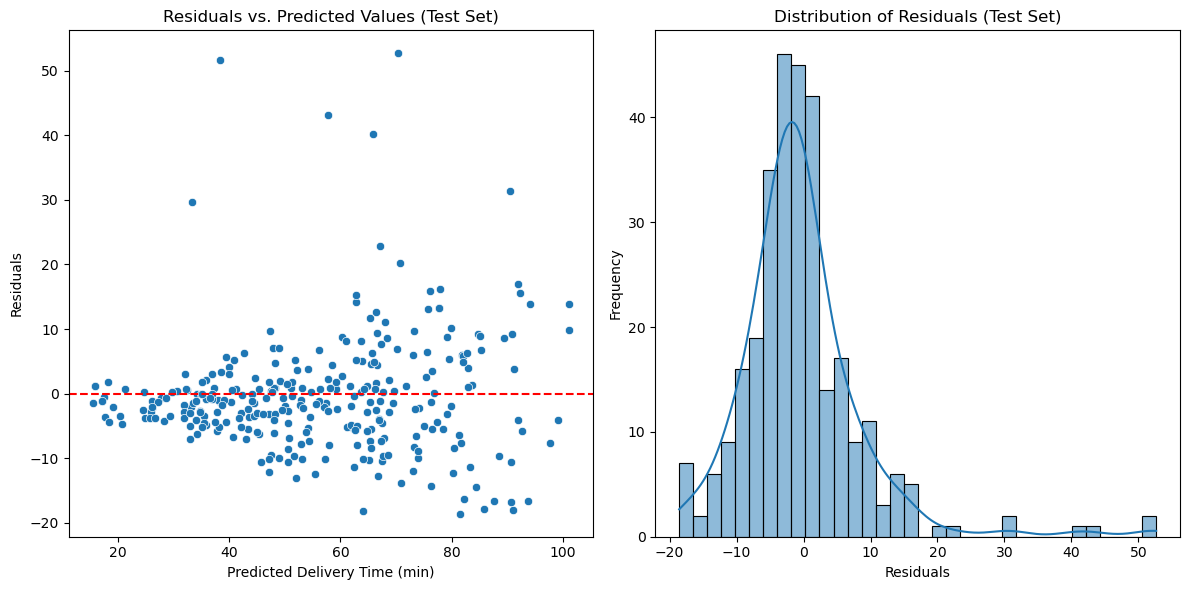

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals for the test set
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 6))

# Plotting residuals vs. predicted values
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Delivery Time (min)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Test Set)')

# Plotting distribution of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set)')

plt.tight_layout()
plt.show()

### Step 8: Save Model and Preprocessor

To prepare for potential deployment or use in an application like Streamlit, we will save our trained Linear Regression model and the `preprocessor` pipeline using `joblib`. This allows us to load them later without retraining.

In [13]:
import joblib

# Save the trained Linear Regression model
joblib.dump(linear_model, '../model/linear_regression_model.joblib')
print("Linear Regression model saved as 'linear_regression_model.joblib'")

# Save the preprocessor
joblib.dump(preprocessor, '../model/preprocessor.joblib')
print("Preprocessor saved as 'preprocessor.joblib'")

Linear Regression model saved as 'linear_regression_model.joblib'
Preprocessor saved as 'preprocessor.joblib'


### Final Conclusion

In this notebook, we successfully performed the essential steps for feature engineering and established a baseline machine learning model. We started by splitting our data into training, validation, and test sets. Then, we applied robust preprocessing steps using `StandardScaler` for numerical features and `OneHotEncoder` for categorical features, transforming our raw data into a format suitable for machine learning.

We built and trained a Linear Regression model, which served as our baseline for predicting food delivery times. The model achieved an R-squared score of **0.82** on the validation set and **0.85** on the test set, indicating that it explains a significant portion of the variance in delivery times. The Mean Squared Error (MSE) values of **105.02** (validation) and **62.75** (test) provide a measure of the average squared difference between predicted and actual delivery times.

The residual analysis suggests that the model's errors are generally centered around zero, which is a good sign. However, further investigation into potential patterns in the residual plots could reveal opportunities for model improvement or the need for more complex models. This baseline provides a strong foundation for future iterations, where we can explore advanced models, hyperparameter tuning, and more sophisticated feature engineering techniques to further enhance prediction accuracy.